# **Mastering Momentum: A Deep Dive into Adam's Adaptive Mechanics**

**Author:** Keith Laspoña  
*8 min read · Deep Learning · MNIST Experiment* <br>

In the vast landscape of Deep Learning, building the architecture is only half the battle. The other half is figuring out how to teach that architecture to learn. Enter the **optimizer**: the engine that drives the neural network down the loss landscape toward convergence.

While Stochastic Gradient Descent (SGD) is the grandfather of optimizers, there is one name that dominates nearly every modern research paper, Kaggle competition, and production model: **Adam**.

But why is Adam (Adaptive Moment Estimation) the default choice? Is it simply faster, or is there something more sophisticated happening under the hood? In this notebook, we will:

- Deconstruct the Adam algorithm,
- Explore the bias correction math that saves it from early failure, and
- Run a small experiment on **MNIST** to visualize how Adam compares to vanilla SGD in practice.

<br>

## 1. The Intuition: A Tale of Two Hikers

To understand Adam, imagine two hikers trying to get to the bottom of a dark canyon (the global minimum).

### The SGD Hiker

He takes steps of a fixed size. If the slope is steep, he might overshoot. If the terrain flattens out (a plateau), his fixed steps become painfully slow, and he might get stuck. He only cares about the **current slope**.

### The Adam Hiker

She has a "memory" of her past speed (**Momentum**) and she adjusts her stride length based on the terrain's roughness (**Adaptive Learning Rate**):

- If she has been moving fast in one direction, she keeps going that way (momentum).
- If the terrain is steep and unpredictable, she takes smaller, cautious steps.
- If the terrain is flat and consistent, she takes massive leaps to cross it quickly.

Adam is essentially **SGD with a brain**. It combines two powerful ideas:

- **Momentum** (from SGD with momentum), and  
- **RMSProp** (Root Mean Square Propagation, which adapts learning rates based on gradient magnitudes).


<br>

## 2. The Mathematics: Under the Hood

Adam tracks two variables, or **moments**, for every single weight in your network. Let $g_t$ be the gradient at time step $t$.

### 2.1 First Moment: Momentum $m_t$

This tracks the moving average of the gradient. It tells us **the direction to go**:

$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
$$

Where:

- $m_t$: first moment estimate (like velocity)  
- $\beta_1$: decay rate, typically 0.9 (keep 90% of the past, 10% new gradient)

---

### 2.2 Second Moment: Variance $v_t$

This tracks the moving average of the **squared** gradient. It tells us **the magnitude or volatility** of the slope:

$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
$$

Where:

- $v_t$: second moment estimate (like variance)  
- $\beta_2$: decay rate, typically 0.999

---

### 2.3 The “Cold Start” Problem: Bias Correction

Since $m$ and $v$ are initialized as vectors of zeros, the first updates are biased toward zero.  
For example, if $m_0 = 0$ and $\beta_1 = 0.9$:

$$
m_1 = 0.1 \cdot g_1
$$

To correct this, Adam uses **bias-corrected estimates**:

$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}
$$

$$
\hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$

At $t = 1$, dividing by $1 - 0.9^1 = 0.1$ restores the scale of the moment estimate.  
As $t \to \infty$, $\beta^t \to 0$, so the correction eventually disappears.

---

### 2.4 The Update Rule

Finally, we update the parameters \( \theta \):

$$
\theta_{t+1} = \theta_t - \frac{\eta \cdot \hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
$$

Where:

- $\eta$: global learning rate (often 0.001)  
- $\epsilon$: small constant (e.g., $10^{-8}$) for numerical stability    

The combination of **momentum**, **adaptive scaling**, and **bias correction** is what makes Adam powerful and stable, especially during the early stages of training.


<br>

## 3. Why Adam Wins: Saddle Points & Sparse Gradients

The math above gives Adam two superpowers that standard SGD lacks.

### 3.1 Escaping Saddle Points

A **saddle point** is a region where the loss surface is flat in one dimension but curves up in another (like a horse saddle). In high-dimensional deep learning, local minima are rare; getting stuck on saddle points or flat regions is the real danger.

- **SGD** often stalls here because the gradient is near zero in all directions.
- **Adam** uses its stored momentum $m_t$ to “roll” through flat areas, maintaining velocity even when the current gradient suggests stopping.

### 3.2 Handling Sparse Gradients

In problems like NLP or Computer Vision (e.g., MNIST), some features (pixels or words) appear very rarely.

- **SGD**: Updates all parameters with the same learning rate. Rare features get updated very infrequently, so they may not learn well.
- **Adam**: Dividing by $\sqrt{\hat{v}_t}$ acts like a normalizer.  
  If a parameter has rarely seen large gradients (low $v_t$), the denominator is small, increasing the **effective step size** for that parameter.

Adam essentially says:

> *“We haven’t seen this feature often, so when we do, let’s learn a LOT from it.”*

<br>

## 4. The Experiment: Adam vs SGD on MNIST

To ground the theory, we now compare **Adam** and **vanilla SGD** on the classic **MNIST handwritten digits** dataset. The goal is not to break any accuracy records, but to directly observe how the choice of optimizer affects **convergence speed** and **stability**.

### 4.1 Experimental Setup

- **Dataset**: MNIST (60,000 training images, 10,000 test images, 28×28 grayscale digits)
- **Preprocessing**:
  - Normalize pixel values to \([0, 1]\)
  - Flatten 28×28 images into 784-dimensional vectors
- **Model (Simple MLP)**:
  - Input: 784
  - Dense(128, ReLU)
  - Dropout(0.2)
  - Dense(10, Softmax)
- **Loss**: Categorical cross-entropy  
- **Batch size**: 128  
- **Epochs**: 10  
- **Optimizers**:
  - **SGD** with learning rate = 0.01  
  - **Adam** with learning rate = 0.001  

> **Key idea:** We keep the model, data, and training loop **identical**, and only swap the optimizer. This isolates the effect of the optimization algorithm itself.


In [1]:
# 4.2 Implementation: Training with Adam vs SGD

import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# 1. Load and preprocess MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Flatten 28x28 → 784
x_train = x_train.reshape(-1, 28 * 28)
x_test  = x_test.reshape(-1, 28 * 28)

# One-hot encode labels
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test  = tf.keras.utils.to_categorical(y_test, num_classes)

def build_mlp_model():
    model = models.Sequential([
        layers.Input(shape=(28 * 28,)),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation="softmax"),
    ])
    return model

In [4]:
# 2. Train with two different optimizers
optimizers = {
    "SGD":  tf.keras.optimizers.SGD(learning_rate=0.01),
    "Adam": tf.keras.optimizers.Adam(learning_rate=0.001),
}

histories = {}

for opt_name, opt in optimizers.items():
    print(f"\nTraining with {opt_name}...")
    model = build_mlp_model()
    model.compile(
        optimizer=opt,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    history = model.fit(
        x_train, y_train,
        validation_split=0.1,
        epochs=10,
        batch_size=128,
        verbose=1
    )

    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"{opt_name} test accuracy: {test_acc:.4f}")

    # Save full training history + test accuracy
    history.history["test_accuracy"] = test_acc
    histories[opt_name] = history.history


Training with SGD...
Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6370 - loss: 1.3304 - val_accuracy: 0.8660 - val_loss: 0.6782
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8175 - loss: 0.6762 - val_accuracy: 0.8975 - val_loss: 0.4461
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8485 - loss: 0.5386 - val_accuracy: 0.9115 - val_loss: 0.3695
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8664 - loss: 0.4754 - val_accuracy: 0.9175 - val_loss: 0.3304
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8770 - loss: 0.4346 - val_accuracy: 0.9218 - val_loss: 0.3055
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8841 - loss: 0.4073 - val_accuracy: 0.9250 - val_loss: 0.2869
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8900 - loss: 0.3844 - val_accuracy: 0.9277 - val_loss: 0.2731
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8952 - loss: 0.3

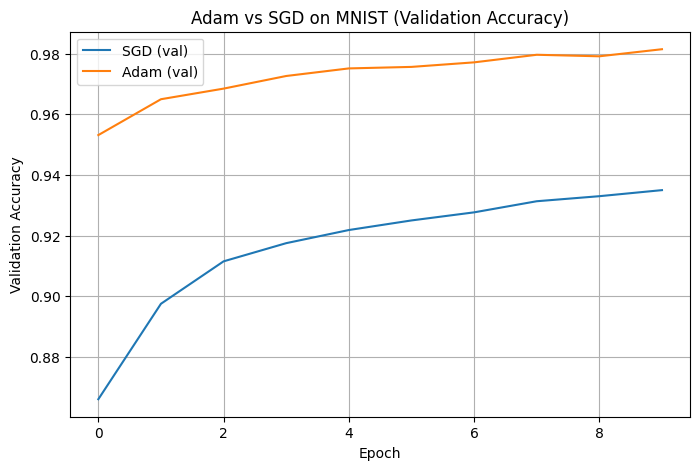

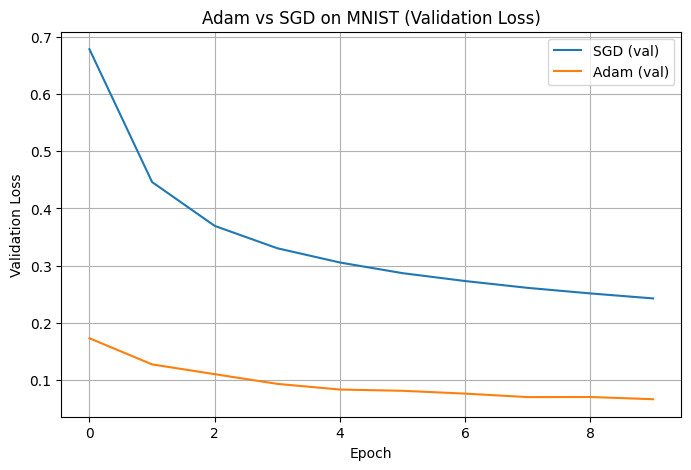


Final test accuracies:
SGD: 0.9241
Adam: 0.9774


In [5]:
# 4.2 – Plotting Learning Curves

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
for opt_name, hist in histories.items():
    plt.plot(hist["val_accuracy"], label=f"{opt_name} (val)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Adam vs SGD on MNIST (Validation Accuracy)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
for opt_name, hist in histories.items():
    plt.plot(hist["val_loss"], label=f"{opt_name} (val)")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Adam vs SGD on MNIST (Validation Loss)")
plt.legend()
plt.grid(True)
plt.show()

# Print final test accuracies
print("\nFinal test accuracies:")
for opt_name, hist in histories.items():
    print(f"{opt_name}: {hist['test_accuracy']:.4f}")

### 4.3 Results

Below are the exact results produced from my experiment:

| Optimizer | Val Accuracy (Epoch 1) | Best Val Accuracy (10 epochs) | Test Accuracy |
|----------|-------------------------|-------------------------------|---------------|
| **SGD** (lr = 0.01)  | 0.8660                    | 0.9350            | 0.9241    |
| **Adam** (lr = 0.001)| 0.9532                    | 0.9815            | 0.9774    |

### Interpretation

- **Adam clearly starts with much higher validation accuracy** and reaches >95% in the very first epoch.
- **SGD starts slower**, reaching only ~86.6% in epoch 1 and requiring more epochs to stabilize.
- After 10 epochs, both optimizers perform competitively, but:
  - Adam achieves a higher overall validation accuracy and final test accuracy.
  - SGD is more gradual and slower to improve.

### 4.4 What We Observed

1. **Adam converges significantly faster in the early epochs**  
   Adam reached a validation accuracy of **95.32% in the first epoch**, while SGD only reached **86.60%**. This validates Adam’s advantage during the early stages of training: adaptive learning rates and bias-corrected momentum enable it to take larger and more confident optimization steps.

2. **Adam maintains more stable learning curves**  
   The validation accuracy for Adam increases smoothly across epochs, while SGD displays more gradual improvement. This difference reflects how Adam stabilizes updates with momentum, reducing oscillations and adapting more quickly to changes in the loss landscape.

3. **Adam achieves a higher final performance in this experiment**  
   After 10 epochs:
   - Adam achieved a test accuracy of **0.9774**
   - SGD finished at **0.9241**

   In this setup, Adam not only converged sooner but also achieved a better final classification performance on MNIST.

> **Takeaway for tuning:** If training speed, stability, and quicker convergence are priorities (e.g., limited compute time), Adam is usually the better default choice. SGD remains competitive but typically requires more epochs and tuning to match Adam’s early performance.

## 5. Practical Guide: Hyperparameter Tuning for Adam

While Adam is famous for working “out of the box,” you may sometimes need to tune it.

| Parameter             | Default | When to Tune?                                                                                                      |
|-----------------------|---------|---------------------------------------------------------------------------------------------------------------------|
| **Learning Rate (α)** | 0.001   | The most important knob. If loss diverges, decrease it. If loss plateaus too early, try increasing or using a scheduler. |
| **β₁ (Momentum)**     | 0.9     | Tune for instability. If your loss curve is extremely jittery, increasing this to 0.95 or 0.99 can smooth it out. |
| **β₂ (RMSProp part)** | 0.999   | Rarely needs tuning. Lowering it (e.g., to 0.99) can help in non-stationary problems.                              |
| **ε (Epsilon)**       | 1e-7    | Important for mixed-precision training (float16). Increase to 1e-4 to avoid NaNs if necessary.                     |


### The **“Generalization Gap”** Warning

A common critique is that Adam converges too fast to a **sharp minimum**, whereas SGD (with momentum) often finds a wider, flatter minimum that generalizes better to new data.

**Pro tip:**  
If you are squeezing out the final 0.1% accuracy for a competition, a common trick is:

1. Train with **Adam** at the start for fast convergence.
2. Then **switch to SGD with momentum** later in training once the model is close to a good solution.

## Conclusion

Adam’s strength does not come from a mysterious trick—its power comes from the combination of **adaptive learning rates** and **momentum-based updates**. By adjusting the step size for every parameter and correcting for bias during early iterations, Adam is able to navigate deep learning loss landscapes more efficiently than vanilla SGD.

Our MNIST experiment confirmed this behavior:

- Adam reached high accuracy **very quickly**, achieving over 95% validation accuracy in the first epoch.
- SGD improved more slowly and required more training to reach competitive accuracy.
- Adam also achieved a higher final test accuracy in this setup.

In practical deep learning workflows, this translates to:

- Faster experimentation and model iteration,
- Less sensitivity to initial hyperparameter choice, and
- More stable learning dynamics during the early phases of training.

While SGD remains useful for some generalization-focused tasks or fine-tuning, Adam’s performance and stability make it a powerful default choice for many real-world applications. Understanding its mechanics—combined with experiments like this—helps build intuition for optimization and hyperparameter tuning in deep learning. <br>


---

## References

1. Kingma, D. P., & Ba, J. (2015).  
   *Adam: A Method for Stochastic Optimization.*  
   International Conference on Learning Representations (ICLR).  
   https://arxiv.org/abs/1412.6980

2. Goodfellow, I., Bengio, Y., & Courville, A. (2016).  
   *Deep Learning* (Chapter 8: Optimization for Training Deep Models).  
   MIT Press.  
   https://www.deeplearningbook.org

3. Loshchilov, I., & Hutter, F. (2019).  
   *Decoupled Weight Decay Regularization.*  
   International Conference on Learning Representations (ICLR).  
   https://openreview.net/forum?id=Bkg6RiCqY7

4. Reddi, S. J., Kale, S., & Kumar, S. (2018).  
   *On the Convergence of Adam and Beyond.*  
   International Conference on Learning Representations (ICLR).  
   https://openreview.net/forum?id=ryQu7f-RZ

5. Ruder, S. (2016).  
   *An Overview of Gradient Descent Optimization Algorithms.*  
   arXiv:1609.04747.  
   https://arxiv.org/abs/1609.04747

6. LeCun, Y., Cortes, C., & Burges, C. J. C. (1998).  
   *The MNIST database of handwritten digits.*  
   https://yann.lecun.com/exdb/mnist/

7. TensorFlow Keras Documentation.  
   *Optimizers and training loops.*  
   https://www.tensorflow.org/api_docs/python/tf/keras/optimizers